In [18]:
# Cell 1: Imports & Paths
import os
from PIL import Image
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.amp import autocast, GradScaler
import matplotlib.pyplot as plt
import geopandas as gpd

BASE_DIR  = '/kaggle/input/datanasa/'
QS_DIR    = os.path.join(BASE_DIR, 'visualization_outputUp', 'Qs')



In [19]:
# Cell 2: Hyperparams and settings
T          = 6       # nombre de pas historiques
DELTA      = 6       # horizon à +6 jours
BATCH_SIZE = 1       # batch size pour la mémoire
LR         = 1e-4    # learning rate
EPOCHS     = 50
PATIENCE   = 8
DEVICE     = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

EXTENT     = [-125, -67, 25, 53]  # étendue géographique
THRESHOLD  = 0.1                  # seuil pour classification


In [20]:
# Cell 3: Filenames & date list
fns = sorted([fn for fn in os.listdir(QS_DIR) if fn.endswith('.png')])
dates = [fn[:-4] for fn in fns]
print(f"Found {len(dates)} dates, e.g. {dates[:3]}")

Found 449 dates, e.g. ['A19790102', 'A19790103', 'A19790104']


In [21]:
# Cell 4: Reference size & downsample ×2
with Image.open(os.path.join(QS_DIR, fns[0])).convert('L') as img:
    W0, H0 = img.size
W0 //= 2
H0 //= 2
print(f"Using size H0={H0}, W0={W0}")

Using size H0=475, W0=847


In [22]:
# Cell 5: Loader (grayscale, resize, normalize)
def load_gray(path):
    img = Image.open(path).convert('L')
    img = img.resize((W0, H0), Image.BILINEAR)
    return np.array(img, dtype=np.float32) / 255.0


In [23]:
# Cell 6: Dataset & DataLoader (QS only)
class RunoffQSDataset(Dataset):
    def __init__(self, dates):
        self.dates = dates
    def __len__(self):
        return len(self.dates) - T - DELTA + 1
    def __getitem__(self, idx):
        window = self.dates[idx:idx+T]
        X_list = [load_gray(os.path.join(QS_DIR, f"{d}.png")) for d in window]
        X = np.stack(X_list).reshape(T, 1, H0, W0)
        y_d = self.dates[idx + T + DELTA - 1]
        y = load_gray(os.path.join(QS_DIR, f"{y_d}.png"))
        return (
            torch.tensor(X, dtype=torch.float32),
            torch.tensor(y, dtype=torch.float32).unsqueeze(0)
        )

ds = RunoffQSDataset(dates)
n_train = int(0.8 * len(ds))
train_ds, val_ds = torch.utils.data.random_split(ds, [n_train, len(ds)-n_train])
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=2)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=2)



In [24]:
# Cell 7: ConvLSTM model definition
class ConvLSTMCell(nn.Module):
    def __init__(self, in_ch, hid_ch, k):
        super().__init__()
        p = k // 2
        self.conv   = nn.Conv2d(in_ch + hid_ch, 4 * hid_ch, k, padding=p)
        self.hid_ch = hid_ch

    def forward(self, x, h, c):
        combined = torch.cat([x, h], dim=1)
        gates    = self.conv(combined)
        i, f, o, g = gates.chunk(4, dim=1)
        i = torch.sigmoid(i)
        f = torch.sigmoid(f)
        o = torch.sigmoid(o)
        g = torch.tanh(g)
        c_next = f * c + i * g
        h_next = o * torch.tanh(c_next)
        return h_next, c_next

    def init_hidden(self, batch_size, height, width, device):
        h = torch.zeros(batch_size, self.hid_ch, height, width, device=device)
        c = torch.zeros(batch_size, self.hid_ch, height, width, device=device)
        return h, c

class ConvLSTMForecaster(nn.Module):
    def __init__(self, in_ch=1, hid_ch=8, k=3, T=6):
        super().__init__()
        self.T        = T
        self.cell     = ConvLSTMCell(in_ch, hid_ch, k)
        self.conv_out = nn.Conv2d(hid_ch, 1, kernel_size=1)

    def forward(self, x):
        B, _, _, H, W = x.size()
        h, c = self.cell.init_hidden(B, H, W, x.device)
        for t in range(self.T):
            h, c = self.cell(x[:, t], h, c)
        return self.conv_out(h)

model     = ConvLSTMForecaster(in_ch=1, hid_ch=8, k=3, T=T).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=1e-4)
scheduler = ReduceLROnPlateau(optimizer, factor=0.5, patience=5, verbose=True)
criterion = nn.MSELoss()
scaler    = GradScaler()


In [25]:
# Cell 8: Training loop + accuracy metrics
best_val     = float('inf')
patience     = PATIENCE
train_losses = []
val_losses   = []

for epoch in range(1, EPOCHS+1):
    model.train()
    train_loss = 0.0
    for X, Y in train_loader:
        X, Y = X.to(DEVICE), Y.to(DEVICE)
        optimizer.zero_grad()
        # use autocast with the device type as positional argument
        with autocast(DEVICE.type):
            pred = model(X)
            loss = criterion(pred, Y)
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        scaler.step(optimizer)
        scaler.update()
        train_loss += loss.item() * X.size(0)

    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)

    model.eval()
    val_loss     = 0.0
    correct_cls  = 0
    correct_tol  = 0
    total_pixels = 0
    with torch.no_grad():
        for X, Y in val_loader:
            X, Y = X.to(DEVICE), Y.to(DEVICE)
            pred = model(X)
            val_loss += criterion(pred, Y).item() * X.size(0)
            pred_bin = (pred > THRESHOLD).float()
            y_bin    = (Y > THRESHOLD).float()
            correct_cls += (pred_bin == y_bin).sum().item()
            abs_err = torch.abs(pred - Y)
            correct_tol += (abs_err < THRESHOLD).sum().item()
            total_pixels += Y.numel()

    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)
    acc_cls = correct_cls / total_pixels
    acc_tol = correct_tol / total_pixels
    print(f"Epoch {epoch:02d} — Train MSE: {train_loss:.4f}, Val MSE: {val_loss:.4f}, "
          f"Acc_classif: {acc_cls*100:.2f}%, Acc_tol (±{THRESHOLD}): {acc_tol*100:.2f}%")
    scheduler.step(val_loss)

    if val_loss < best_val:
        best_val = val_loss
        torch.save(model.state_dict(), 'best_qs_only.pth')
        patience = PATIENCE
    else:
        patience -= 1
        if patience == 0:
            print("Early stopping.")
            break

    torch.cuda.empty_cache()


Epoch 01 — Train MSE: 0.9108, Val MSE: 0.0092, Acc_classif: 98.54%, Acc_tol (±0.1): 91.15%
Epoch 02 — Train MSE: 0.0089, Val MSE: 0.0088, Acc_classif: 98.54%, Acc_tol (±0.1): 91.09%
Epoch 03 — Train MSE: 0.0084, Val MSE: 0.0081, Acc_classif: 98.58%, Acc_tol (±0.1): 91.15%
Epoch 04 — Train MSE: 0.0077, Val MSE: 0.0073, Acc_classif: 98.64%, Acc_tol (±0.1): 91.15%
Epoch 05 — Train MSE: 0.0068, Val MSE: 0.0063, Acc_classif: 98.78%, Acc_tol (±0.1): 91.94%
Epoch 06 — Train MSE: 0.0056, Val MSE: 0.0050, Acc_classif: 98.97%, Acc_tol (±0.1): 92.46%
Epoch 07 — Train MSE: 0.0041, Val MSE: 0.0034, Acc_classif: 99.26%, Acc_tol (±0.1): 92.81%
Epoch 08 — Train MSE: 0.0028, Val MSE: 0.0024, Acc_classif: 99.55%, Acc_tol (±0.1): 94.46%
Epoch 09 — Train MSE: 0.0021, Val MSE: 0.0019, Acc_classif: 99.74%, Acc_tol (±0.1): 95.03%
Epoch 10 — Train MSE: 0.0016, Val MSE: 0.0015, Acc_classif: 99.77%, Acc_tol (±0.1): 96.11%
Epoch 11 — Train MSE: 0.0013, Val MSE: 0.0012, Acc_classif: 99.78%, Acc_tol (±0.1): 97.34%

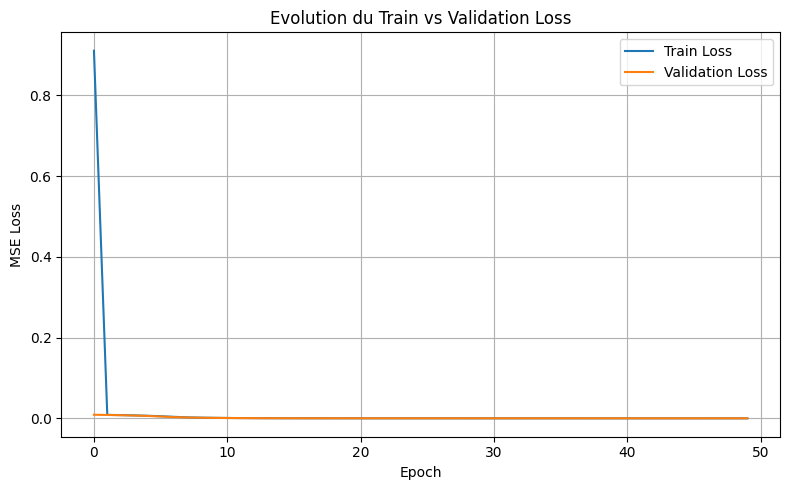

In [26]:
# Cell 9: Visualisation des losses
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses,   label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Evolution du Train vs Validation Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [27]:
# Cell 10: Évaluation R² & MAE
model.eval()
import numpy as np
ss_res = 0.0
ss_tot = 0.0
mae_sum = 0.0
n_pixels = 0
all_y = []
with torch.no_grad():
    for X, Y in val_loader:
        X, Y = X.to(DEVICE), Y.to(DEVICE)
        pred = model(X)
        y_true = Y.view(-1).cpu().numpy()
        y_pred = pred.view(-1).cpu().numpy()
        ss_res += np.sum((y_true - y_pred)**2)
        mae_sum += np.sum(np.abs(y_true - y_pred))
        n_pixels += y_true.size
        all_y.append(y_true)
all_y = np.concatenate(all_y)
y_mean = all_y.mean()
ss_tot = np.sum((all_y - y_mean)**2)
r2  = 1 - (ss_res / ss_tot)
mae = mae_sum / n_pixels
print(f"R² : {r2:.4f}, MAE : {mae:.4f}")

R² : 0.9858, MAE : 0.0055


In [28]:
# Cell 11: Sauvegarde finale du modèle
MODEL_SAVE_PATH = 'model_final_qs_only.pth'
torch.save(model.state_dict(), MODEL_SAVE_PATH)
print(f"Modèle sauvegardé dans {MODEL_SAVE_PATH}")

Modèle sauvegardé dans model_final_qs_only.pth


In [29]:
model_code = """
import torch
import torch.nn as nn

class ConvLSTMCell(nn.Module):
    def __init__(self, in_ch, hid_ch, k):
        super().__init__()
        p = k // 2
        self.conv   = nn.Conv2d(in_ch + hid_ch, 4 * hid_ch, k, padding=p)
        self.hid_ch = hid_ch

    def forward(self, x, h, c):
        combined = torch.cat([x, h], dim=1)
        gates    = self.conv(combined)
        i, f, o, g = gates.chunk(4, dim=1)
        i = torch.sigmoid(i); f = torch.sigmoid(f)
        o = torch.sigmoid(o); g = torch.tanh(g)
        c_next = f * c + i * g
        h_next = o * torch.tanh(c_next)
        return h_next, c_next

    def init_hidden(self, batch_size, height, width, device):
        h = torch.zeros(batch_size, self.hid_ch, height, width, device=device)
        c = torch.zeros(batch_size, self.hid_ch, height, width, device=device)
        return h, c

class ConvLSTMForecaster(nn.Module):
    def __init__(self, in_ch, hid_ch, k, T):
        super().__init__()
        self.T        = T
        self.cell     = ConvLSTMCell(in_ch, hid_ch, k)
        self.conv_out = nn.Conv2d(hid_ch, 1, kernel_size=1)

    def forward(self, x):
        B, _, _, H, W = x.size()
        h, c = self.cell.init_hidden(B, H, W, x.device)
        for t in range(self.T):
            h, c = self.cell(x[:, t], h, c)
        return self.conv_out(h)
"""
with open("model.py", "w") as f:
    f.write(model_code)
print("model.py créé avec succès")


model.py créé avec succès


Dataset size: 438


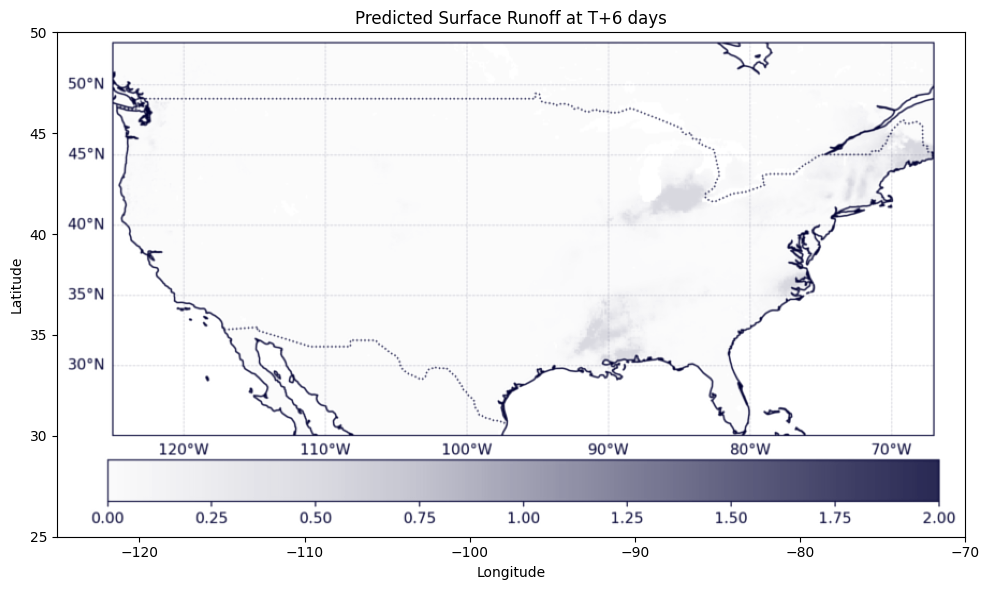

In [30]:
# Cell 13: Inference (QS only)
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from model import ConvLSTMForecaster

DEVICE     = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
MODEL_PATH = 'model_final_qs_only.pth'
EXTENT     = (-125, -70, 25, 50)

model = ConvLSTMForecaster(in_ch=1, hid_ch=8, k=3, T=T).to(DEVICE).eval()
state = torch.load(MODEL_PATH, map_location=DEVICE, weights_only=True)
model.load_state_dict(state)

# sélectionner un échantillon
print("Dataset size:", len(ds))
idx = len(ds) - 1
X0, _ = ds[idx]

X0_batch = X0.unsqueeze(0).to(DEVICE)
with torch.no_grad():
    pred_norm = model(X0_batch).cpu().squeeze().numpy()

pred_qs      = pred_norm * 2.0
data_to_plot = np.flipud(pred_qs)

plt.style.use('default')
fig, ax = plt.subplots(figsize=(10, 6), facecolor='white')
colors = ['#000033', '#ffffff']
cmap   = LinearSegmentedColormap.from_list('dark_blue', colors)
im = ax.imshow(
    data_to_plot, origin='lower', extent=EXTENT,
    vmin=0, vmax=2, cmap=cmap, aspect='auto'
)
ax.set(xlabel='Longitude', ylabel='Latitude', title='Predicted Surface Runoff at T+6 days')
plt.tight_layout()
plt.show()
